In [1]:
import pandas as pd

import numpy as np

from itertools import combinations

import networkx as nx

import os 

import pickle

import matplotlib.pyplot as plt

from matplotlib import font_manager as fm, rcParams

plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签

plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置

pd.set_option("display.max_columns", 50)

pd.set_option("display.max_rows", 260)


In [2]:
# Data Type Transitions - We filling in the null value in parents, spouse, bro-sis, children columns for further steps

def dt_conv(df, col_list):
    for col in col_list:
        df[col] = df[col].fillna(0).astype('int64')
        
def kinhood_relation_filter(col):
    filter_list = [item for item in col.split(' ') if '(' not in item]
    fin_rel = " ".join(filter_list)
    return(fin_rel)

def network_metric_merge(network, label, iteration = 100):
    
    degree = pd.DataFrame(network.degree).rename(columns={0:'celebrity',1:'degrees'})

    degree_centrality = pd.DataFrame(nx.degree_centrality(network).values(), index = nx.degree_centrality(network).keys()).reset_index().rename(columns={'index':'celebrity',0:'degrees_centrality'})

    betweenness_centrality = pd.DataFrame(nx.betweenness_centrality(network).values(), index = nx.betweenness_centrality(network).keys()).reset_index().rename(columns={'index':'celebrity',0:'betweenness_centrality'})

    closeness_centrality = pd.DataFrame(nx.closeness_centrality(network).values(), index = nx.closeness_centrality(network).keys()).reset_index().rename(columns={'index':'celebrity',0:'closeness_centrality'})

    eigenvector_centrality = pd.DataFrame(nx.eigenvector_centrality(network, max_iter = iteration).values(), index = nx.eigenvector_centrality(network, max_iter = iteration).keys()).reset_index().rename(columns={'index':'celebrity',0:'eigenvector_centrality'})

    aggregated_dataframe = degree.merge(degree_centrality, left_on = 'celebrity', right_on = 'celebrity').merge(betweenness_centrality, left_on = 'celebrity', right_on = 'celebrity').merge(closeness_centrality, left_on = 'celebrity', right_on = 'celebrity').merge(eigenvector_centrality, left_on = 'celebrity', right_on = 'celebrity')
    
    aggregated_dataframe.loc[:,label] = 1
    
    return(aggregated_dataframe)

In [3]:
# Read in what needs to be Web-scraped
hc_df = pd.read_excel('C:/Users/lenovo/a_Research/input/Human_Capital_1.0.0.xlsx')
hmcpt_df = hc_df.copy()
fill_in_df = hc_df[(hc_df.loc[:,'homeplace'].isna()) | (hc_df.loc[:,'academy1'].isna())].reset_index(drop=True)

# Read in Web-scraped content
filled_in_df = pd.read_csv('C:/Users/lenovo/a_Research/Apr24_Latest_Data.csv', header=0).reset_index(drop=True)
filled_in_df.columns = ['name', 'homeplace', 'graduate']

# Read in What-I-Don't-Know
# actor_list_pk = pd.read_pickle('C:/Users/lenovo/a_Research/actor_list.pickled')
# actor_list_df = pd.DataFrame(actor_list_pk).T.reset_index()
# actor_list_df.columns = ['name', 'homeplace', 'graduate']

In [4]:
fill_in_df_copy = fill_in_df[['name', 'homeplace', 'academy1']]

# df_actor_comparison = fill_in_df_copy.merge(actor_list_df, how = 'left', left_on='name', right_on='name')

df_latest_comparison = fill_in_df_copy.merge(filled_in_df, how = 'left', left_on='name', right_on='name')

# df_actor_comparison.to_csv('df_actor_comparison.csv',index=False)
# df_latest_comparison.to_csv('df_latest_comparison.csv',index=False)

In [5]:
df_updated = df_latest_comparison[ (df_latest_comparison.loc[:,'homeplace_x'].isna() == True) & ((df_latest_comparison.loc[:,'homeplace_y'].isna()) == False | (df_latest_comparison.loc[:,'homeplace_y'] == 'None')) ].reset_index(drop=True)

In [6]:
df_updated

name homeplace_x     academy1 homeplace_y       graduate
0       黄才伦         NaN  中国人民解放军艺术学院        辽宁鞍山        解放军艺术学院
1        蔡珩         NaN       中央戏剧学院         上海市         中央戏剧学院
2     马特·达蒙         NaN          NaN    马萨诸塞州剑桥市           None
3        崔巍         NaN          NaN        山东青岛         北京舞蹈学院
4     丹尼斯·吴         NaN          NaN    美国-德克萨斯州    美国沙凡娜艺术设计大学
...     ...         ...          ...         ...            ...
1030    程一桥         NaN          NaN        江苏徐州         中央戏剧学院
1031     刘欣         NaN          NaN          北京         中央戏剧学院
1032     宣璐         NaN          NaN      江苏省南京市  北京舞蹈学院、中央戏剧学院
1033    武东博         NaN          NaN      山西省朔州市           None
1034    李维康         NaN          NaN          北京         中国戏曲学校

[1035 rows x 5 columns]

### Geo Network Building

In [7]:
%run ~/a_Research/Input/Geographic_Data.py

In [8]:
actor_filled_df = df_updated[['name', 'homeplace_y']].rename(columns={'name':'name','homeplace_y':'homeplace'})

In [9]:
def hp_std(value):

    for pv in province_23_simp_list:

        if pv in value:

            return(pv)
            
        else:
            
            pass

    for mn in municipality_4_simp_list:

        if mn in value:

            return(mn)
            
        else:
            
            pass
        
    for sa in special_administrative_region_2_simp_list:
        
        if sa in value:
            
            return(sa)
        
        else:
            
            pass
        
    for ar in autonomous_region_5_simp_list:

        if ar in value:

            return(ar) 
        
        else:
            
            pass
        
    for st in us_state_50_simp_list:
        
        if st in value or '美国' in value:
            
            return('美国')
        
        else:
            
            pass
        
    for ct in foreign:
        
        if ct in value:
            
            return(ct)
        
        else:
            
            pass

    for place in korea_city:
        
        if place in value:
            
            return('韩国')
        
        else:
            
            pass

    for place in jap_city:
        
        if place in value:
            return('日本')
        else:
            pass
        
    for item in Geo_Mapping_Dict.keys():
        if item in value:
            return(Geo_Mapping_Dict[item])
        else:
            pass

    return(value)


In [10]:
actor_filled_df['homeplace_std'] = actor_filled_df['homeplace'].apply(hp_std).astype('str')

In [11]:
actor_filled_df.loc[(actor_filled_df['name'] == '焦刚')].index
# 焦刚 山东
actor_filled_df.iloc[30,2] = '山东'

In [12]:
joined_list = province_23_simp_list+municipality_4_simp_list+special_administrative_region_2_simp_list+autonomous_region_5_simp_list+us_state_50_simp_list+foreign

In [13]:
actor_filled_df.loc[(~actor_filled_df['homeplace_std'].isin(joined_list)) & (actor_filled_df['homeplace_std'] != '美国') ].reset_index(drop=True)

name         homeplace homeplace_std
0  贾二娃              中国西北          中国西北
1  吕晓霖                东北            东北
2   梦丽           符拉迪沃斯托克       符拉迪沃斯托克
3  伊莉莎  第聂伯罗彼得罗夫斯克市[11]            乌克兰
4  国丽娜                东北            东北
5  胡丽芝                中国            中国

In [14]:
homeplace_nw = hmcpt_df[~hmcpt_df['homeplace'].isna()][['name', 'homeplace']].reset_index(drop=True)

homeplace_nw['homeplace_std'] = homeplace_nw['homeplace'].apply(hp_std).astype('str')

In [15]:
# Examination
homeplace_nw.loc[(~homeplace_nw['homeplace_std'].isin(joined_list)) & (homeplace_nw['homeplace_std'] != '美国') ].reset_index(drop=True)

name homeplace homeplace_std
0     吴尊        文莱            文莱
1    关智斌       菲律宾           菲律宾
2  阿拉腾乌拉        蒙古            蒙古
3    张钧甯        德国            德国

In [16]:
homeplace_network = pd.concat([actor_filled_df,homeplace_nw],axis=0).reset_index(drop=True)

In [17]:
homeplace_network = homeplace_network.loc[~homeplace_network['homeplace_std'].isin(['中国','中国西北','东北'])].reset_index(drop=True)

In [18]:
homeplace_network = homeplace_network[['name','homeplace_std']].rename(columns={'name':'name','homeplace_std':'Sorted_Homeplace'})

In [150]:
homeplace_network.to_csv('homeplace_network.csv',index=False)

In [19]:
homeplace_network['Peoplelist'] = homeplace_network['name'].apply(lambda x: x.split())

In [21]:
agg2 = homeplace_network.groupby('Sorted_Homeplace')['Peoplelist'].agg(sum)

In [153]:
# set_test = set()
# for item in agg2:
#     for var in item:
#         set_test.update(item)
# len(set_test)

In [26]:
homeplace_agg

Sorted_Homeplace                                         Peoplelist
0                上海  [蔡珩, 翟巍, 孙祖杨, 朱雨辰, 芦芳生, 保剑锋, 李正翔, 赵有亮, 陆昱霖, 陈冲...
1               乌克兰                                              [伊莉莎]
2                云南  [扎西顿珠, 夏嘉伟, 黄成麟, 晋松, 郝柏杰, 李佳怡, 胡静, 童瑶, 李佳, 王嘉,...
3               内蒙古  [阿如那, 涂们, 傅亨, 乌达木, 乌日根, 王宇泽, 宋佳伦, 王煜, 张秋歌, 王萌,...
4               加拿大                 [关楚耀, 郑欣宜, 林嘉欣, 锦荣, 蔡卓妍, 岑丽香, 钟丽缇]
5                北京  [林申, 何冰, 冉旭, 陈伟栋, 冯雷, 刘佩琦, 李左飞, 康恩赫, 谢苗, 杨铮, 刘...
6             印度尼西亚                                              [王宇婕]
7                台湾  [黄品源, 杨祐宁, 宥胜, 邱胜翊, 柯有伦, 石峰, 刘汉强, 张博翔, 焦恩俊, 邱心...
8                吉林  [郭凯敏, 魏大勋, 李幼斌, 刘思博, 陈昊, 郑昊, 何中华, 蓝波, 卢海华, 杨猛,...
9                四川  [陈天星, 吕聿来, 段博文, 蒲巴甲, 罗云熙, 曾虹畅, 沈伐, 张默, 徐嘉苇, 孙艺...
10               天津  [午马, 杨议, 王泷正, 黄海波, 闫霖飞, 牛犇, 傅迦, 毛晓彤, 宋祖儿, 穆梦娇,...
11               宁夏                                              [李乃文]
12               安徽  [姜潮, 董玉峰, 葛秋谷, 姜文轩, 杨钧承, 潘昊, 徐僧, 纪宁, 李文, 刘思伟, ...
13               山东  [崔巍, 李晔, 焦刚, 释彦能, 岳松, 杨珑, 夏雨, 王晖, 高曙光, 郭鑫, 桑伟淋...
14               山西  [何育骏, 贺刚, 邢佳栋, 杜维瀚, 王聪, 成泰燊, 张勇手, 韩立, 阎维文, 童振军...
15               广东  [孙兴, 谭佑铭, 罗家英, 梁家仁, 张敬轩, 梁小龙, 俞灏明, 陈国坤, 黄彦, 凌正...
16               广西           [泰迪罗宾, 盘剑, 王鸥, 谈莉娜, 熊珂, 苏尚卿, 胡夏, 黄觉, 张俪]
17               德国                                              [张钧甯]
18               文莱                                               [吴尊]
19              新加坡                                              [立威廉]
20               新疆  [赵铭, 于朦胧, 魏建云, 王景春, 陆川, 张正阳, 王鑫尧, 维妮, 蒋欣, 成梓宁,...
21               日本    [安藤政信, 三浦春马, 矢野浩二, 池内博之, 叶山豪, 原岛大地, 中泉英雄, 田中千绘]
22               江苏  [吴奇隆, 李保田, 罗翔, 张峻宁, 金鑫, 侯长荣, 魏冠男, 张优, 何明翰, 王建新...
23               江西  [李泰, 许还山, 吴弘, 朱文超, 田小洁, 石安妮, 刘涛, 江易珈, 甘露, 李依伊,...
24               河北  [楼云飞, 杨子, 高晓攀, 张志宏, 王光辉, 韩兆, 张道兴, 吴樾, 李砚, 刘一江,...
25               河南  [岳云鹏, 赵立新, 李天涯, 王斑, 向昊, 王小毅, 李易祥, 毛孩, 贾之海, 李梦男...
26               泰国                               [唐宸禹, 唐治平, 李海娜, 贝安琪]
27               浙江  [苗侨伟, 华少, 邵兵, 谷尚蔚, 王佑硕, 胡兵, 高瀚宇, 韩栋, 沈涛, 贾云, 徐...
28               海南                                [冯铭潮, 陈旺林, 顾莉雅, 隋源]
29               湖北  [贾一平, 尚于博, 袁弘, 杨采钰, 曹曦月, 居文沛, 卜冠今, 谢容儿, 黄白露, 李...
30               湖南  [周一围, 黄阅, 罗蓝山, 彭宇, 左立, 罗刚, 李岱昆, 李强, 颖儿, 李倩, 李梦...
31             澳大利亚                                            [休·杰克曼]
32               澳门                                         [方中信, 梁洛施]
33               瑞典                                           [彼得·斯特曼]
34               瑞士                                              [李成敏]
35               甘肃  [陈翔, 彭禺厶, 李骏诚, 孙亮, 马晓辉, 汪奇, 安泽豪, 荣梓希, 孙茜, 漆子美,...
36               福建  [龚蓓苾, 陈欣茹, 陈怡凡, 高利虹, 罗梓丹, 董含露, 陈赫, 欧豪, 林峰, 吴孟达...
37          符拉迪沃斯托克                                               [梦丽]
38               美国  [马特·达蒙, 丹尼斯·吴, 凯南·鲁兹, 布兰登·罗斯, 凯文史派西, 李承铉, 丹尼尔·...
39               英国                              [克里斯蒂安·贝尔, 盖·皮尔斯, 焦阳]
40              菲律宾                                              [关智斌]
41               蒙古                                            [阿拉腾乌拉]
42               西藏                                 [阿旺仁青, 洛桑念扎, 索朗卓嘎]
43               贵州  [宋锐贤, 王挺, 班嘉佳, 宁静, 肖雨雨, 卢蒽洁, 周显欣, 齐溪, 于娜, 周韦彤,...
44               越南                                              [吕良伟]
45               辽宁  [黄才伦, 赵英俊, 史元庭, 王德顺, 孙维民, 刘子豪, 隋咏良, 许凝, 孙博, 文松...
46               重庆  [周浩东, 刘牧, 彭波, 李晨浩, 卢奇, 周依然, 何泓姗, 陈紫函, 冯家妹, 刘珈彤...
47               陕西  [小张铎, 付辛博, 王大治, 夏望, 王成阳, 尤勇, 王双宝, 罗京民, 刘伟, 张天柏...
48               青海                           [康磊, 旺卓措, 杨秀措, 贾茹, 西德尼玛]
49               韩国  [郑智薰, 张东健, 李敏镐, 李准基, 宋承宪, 权相宇, 朴灿烈, 车太贤, 安宰贤, ...
50               香港  [黄德斌, 刘锡明, 王喜, 唐文龙, 林耀声, 陈晓东, 彭敬慈, 彭皓锋, 何浩文, 谭...
51             马来西亚        [品冠, 阿牛, 洪乙心, 朱咪咪, 冯宝宝, 曹三丰, 杨紫琼, 李馨巧, 李心洁]
52              黑龙江  [张磊, 林强, 陈霖生, 郭家铭, 廖望, 于博宁, 赵毅新, 黄宏, 佟瑞欣, 潘长江,...

In [154]:
homeplace_agg = agg2.apply(pd.unique).reset_index()

homeplace_agg['network_tuple'] = homeplace_agg['Peoplelist'].apply(lambda x: [*combinations(x, 2)])

In [155]:
homeplace_agg['Peoplelists'] = [list(item)for item in homeplace_agg.Peoplelist]

In [32]:
homeplace_agg = homeplace_agg[homeplace_agg.network_tuple.apply(lambda x : len(x) != 0)].reset_index(drop=True)

homeplace_agg[['Sorted_Homeplace', 'Peoplelists']].to_csv('~/a_Research/Input/Simulation/aggregated_geo_by_edge.csv', index = False)

In [157]:
Geo_network = nx.Graph()

nodes_list = homeplace_agg.Peoplelists.sum()

print(len(nodes_list))

nodes_list = list(set(nodes_list))

print(len(nodes_list))

Geo_network.add_nodes_from(nodes_list)

edges_list = homeplace_agg.network_tuple.sum()

# June.3rd, we've taken care of the self-join

# edges_list = list(set([item for item in df_bi.collab.sum() if item[0] != item[1]]))

Geo_network.add_edges_from(edges_list)

1677
1677


In [67]:
print(len(Geo_network.nodes), len(Geo_network.edges))

1677 69575


In [71]:
# for item in Geo_network.edges:
#     if '林申' in item[0] or '林申' in item[1]: 
#         print(item)

('谢苗', '林申')
('于荣光', '林申')
('耿其昌', '林申')
('刘文卿', '林申')
('吴刚', '林申')
('李小冉', '林申')
('苗苗', '林申')
('张妍', '林申')
('黄一琳', '林申')
('张蓝心', '林申')
('张兰艺', '林申')
('热依扎', '林申')
('孙骁潇', '林申')
('涂松岩', '林申')
('马嘉铭', '林申')
('林申', '何冰')
('林申', '冉旭')
('林申', '陈伟栋')
('林申', '冯雷')
('林申', '刘佩琦')
('林申', '李左飞')
('林申', '康恩赫')
('林申', '杨铮')
('林申', '刘金山')
('林申', '郑拓疆')
('林申', '刘波')
('林申', '秦勇')
('林申', '周德华')
('林申', '白凯南')
('林申', '英达')
('林申', '杨璐')
('林申', '代旭')
('林申', '史磊')
('林申', '王庆祥')
('林申', '李京')
('林申', '廖京生')
('林申', '尚长荣')
('林申', '张旭')
('林申', '李滨')
('林申', '那威')
('林申', '李诚儒')
('林申', '杨子骅')
('林申', '石昊正')
('林申', '侯京健')
('林申', '张双利')
('林申', '杜旭东')
('林申', '吴滨')
('林申', '孙松')
('林申', '武宾')
('林申', '孙天宇')
('林申', '修宗迪')
('林申', '徐昂')
('林申', '丁浩')
('林申', '张京生')
('林申', '莫小棋')
('林申', '牛萌萌')
('林申', '叮当')
('林申', '鞠萍')
('林申', '霍思燕')
('林申', '张美娟')
('林申', '倪慕斯')
('林申', '张蓝艺')
('林申', '赵倩')
('林申', '闫露娢')
('林申', '张瑶')
('林申', '李宇菲')
('林申', '吕丽萍')
('林申', '许芳铱')
('林申', '杨紫')
('林申', '李嘉琪')
('林申', '林源')
('林申', '颜丙燕')
('林申', '齐如意')
('林申', 

In [66]:
# pickle.dump(Geo_network, open('C:/Users/lenovo/a_Research/Input/Simulation/Geo_network.pickle', 'wb'))

Geo_network = pickle.load(open('C:/Users/lenovo/a_Research/Input/Simulation/Geo_network.pickle', 'rb'))

In [74]:
aggregated_geo_network_metrics = network_metric_merge(Geo_network, 'geo_network_indicator', 1000)

aggregated_geo_network_metrics.head()

celebrity  degrees  degrees_centrality  betweenness_centrality  \
0        谢苗      163            0.097255                     0.0   
1       于荣光      163            0.097255                     0.0   
2        谢娜       65            0.038783                     0.0   
3        余男      102            0.060859                     0.0   
4       王学兵       21            0.012530                     0.0   

   closeness_centrality  eigenvector_centrality  geo_network_indicator  
0              0.097255            7.808678e-02                      1  
1              0.097255            7.808678e-02                      1  
2              0.038783            4.868384e-35                      1  
3              0.060859            8.395008e-19                      1  
4              0.012530            4.066300e-75                      1

In [76]:
aggregated_geo_network_metrics.to_csv('~/a_Research/Input/Simulation/aggregated_geo_network_metrics_simu.csv', index = False)

### Alumni Network Building

#### Dealing with info we web-scraped for

In [6]:
# What has been successfully built in
df_updated_edu = df_latest_comparison[ (df_latest_comparison.loc[:,'academy1'].isna() == True) & ((df_latest_comparison.loc[:,'graduate'].isna()) == False | (df_latest_comparison.loc[:,'graduate'] == 'None')) ].reset_index(drop=True)
df_updated_edu

name homeplace_x academy1 homeplace_y        graduate
0       崔巍         NaN      NaN        山东青岛          北京舞蹈学院
1    丹尼斯·吴         NaN      NaN    美国-德克萨斯州     美国沙凡娜艺术设计大学
2       翟巍         NaN      NaN         上海市          华东师范大学
3       吴尊          文莱      NaN          文莱   澳大利亚皇家墨尔本理工大学
4    休·杰克曼         NaN      NaN     澳大利亚-悉尼  悉尼科技大学，伊迪斯科文大学
..     ...         ...      ...         ...             ...
885    张译木         NaN      NaN        黑龙江省          北京电影学院
886    程一桥         NaN      NaN        江苏徐州          中央戏剧学院
887     刘欣         NaN      NaN          北京          中央戏剧学院
888     宣璐         NaN      NaN      江苏省南京市   北京舞蹈学院、中央戏剧学院
889    李维康         NaN      NaN          北京          中国戏曲学校

[890 rows x 5 columns]

In [7]:
df_updated_edu.iloc[df_updated_edu.loc[(df_updated_edu['name'] == '李滨')].index[0],0] = '李滨(男)'
df_updated_edu.iloc[df_updated_edu.loc[(df_updated_edu['name'] == '杨博')].index[0],0] = '杨博(导演)'
df_updated_edu.iloc[df_updated_edu.loc[(df_updated_edu['name'] == '杨博(导演)')].index[0],4] = '北京电影学院'
df_updated_edu.iloc[df_updated_edu.loc[(df_updated_edu['name'] == '林妙可')].index[0],4] = '中国音乐学院附中'

In [8]:
df_updated_edu.iloc[df_updated_edu.loc[(df_updated_edu['name'] == '赵聪')].index[0],4] = '北京戏曲学院、中央戏剧学院'

# Correcting some info

# 2017年5月，张敬轩获法国北欧大学颁授“荣誉商管博士”。9月，获英国伦敦音乐学院颁授荣誉音乐硕士学位。
df_updated_edu.iloc[df_updated_edu.loc[(df_updated_edu['name'] == '张敬轩')].index[0],4] = '广州市五羊金融财经职业学校'


# https://en.wikipedia.org/wiki/Lee_Hyun-jae_(actor)
df_updated_edu.iloc[df_updated_edu.loc[(df_updated_edu['name'] == '李贤宰')].index[0],4] = '百济艺术大学'

# Deleting wrong info
# Samery University has no search result
df_updated_edu.drop(df_updated_edu.loc[(df_updated_edu['name'] == '涂圣成')].index[0],axis=0,inplace=True)
# 信息有误
df_updated_edu.drop(df_updated_edu.loc[(df_updated_edu['name'] == '吴滨')].index[0],axis=0,inplace=True)
# only 音乐学院 is obtained
df_updated_edu.drop(df_updated_edu.loc[(df_updated_edu['name'] == '柯伯龙')].index[0],axis=0,inplace=True)

In [9]:
df_updated_edu.loc[:,'graduate1'] = df_updated_edu['graduate'].str.replace(",","、")
df_updated_edu.loc[:,'graduate2'] = df_updated_edu['graduate1'].str.replace("，","、")

In [10]:
def graduate_academy1(col):
    if '、' not in col:
        return(col)
    else:
        return(col.split('、')[0])    
    
def graduate_academy2(col):
    if '、' in col:
        return(col.split('、')[1])
    else:
        return(np.nan)

In [11]:
df_filled_edu = df_updated_edu[['name','graduate2']]
df_filled_edu.loc[:,'academy1'] = df_filled_edu['graduate2'].apply(graduate_academy1)
df_filled_edu.loc[:,'academy2'] = df_filled_edu.loc[:,'graduate2'].apply(graduate_academy2)
df_filled_edu['academy2'] = df_filled_edu['academy2'].astype('str')
df_filled_edu.loc[:,'academy1_fixed'] = df_filled_edu['academy1'].apply(lambda x: x.split('[')[0])
df_filled_edu.loc[:,'academy2_fixed'] = df_filled_edu['academy2'].apply(lambda x: x.split('[')[0])

<ipython-input-11-442c630cc6db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filled_edu.loc[:,'academy1'] = df_filled_edu['graduate2'].apply(graduate_academy1)
<ipython-input-11-442c630cc6db>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filled_edu.loc[:,'academy2'] = df_filled_edu.loc[:,'graduate2'].apply(graduate_academy2)
<ipython-input-11-442c630cc6db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [12]:
df_filled_edu_updtd = df_filled_edu[['name','academy1_fixed','academy2_fixed']]
df_filled_edu_updtd.columns = ['name','academy1','academy2']

#### Dealing with info we already have before web-scraping

In [13]:
edu_filled_in = hmcpt_df[~hmcpt_df['academy1'].isna() | ~hmcpt_df['academy2'].isna()].reset_index(drop=True)[['name','academy1','academy2']]

In [14]:
edu_filled_in.iloc[edu_filled_in.loc[(edu_filled_in['name'] == '林熙蕾')].index[0],1] = '加利福尼亚大学欧文分校'
edu_filled_in.iloc[edu_filled_in.loc[(edu_filled_in['name'] == '徐子珊')].index[0],1] = '加利福尼亚大学戴维斯分校'
edu_filled_in.iloc[edu_filled_in.loc[(edu_filled_in['name'] == '成龙')].index[0],1] = '香港中国戏剧学院'
edu_filled_in.drop(edu_filled_in.loc[(edu_filled_in['name'] == '吴妍妍')].index[0],axis=0,inplace=True)

In [15]:
Edu_Mapping_Dict = {'中央戏剧学院':'中央戏剧学院', '北京舞蹈学院':'北京舞蹈学院附中'
, 'TVB':'香港无线电视艺员训练班','无线电视艺员训练班':'香港无线电视艺员训练班'
, '伦敦大学':'伦敦大学', 'Macquarie':'麦考瑞大学', '安徽大学':'安徽大学'
, '安徽省艺术学校':'安徽省艺术学校' 
, '澳大利亚皇家墨尔本理工大学':'皇家墨尔本理工大学'                 
,'Rmit':'皇家墨尔本理工大学'
,'澳洲墨尔本皇家技术大学':'皇家墨尔本理工大学','北京大学':'北京大学'
,'北京电影学院':'北京电影学院','北京广播学院':'北京广播学院','北京师范大学':'北京师范大学','北京体育大学':'北京体育大学'
,'北京现代音乐学院':'北京现代音乐学院', '北京演艺专修学院':'北京演艺专修学院', '中北':'北京中北国际演艺专修学校'
, '毕业于香港影视学院':'香港影视学院'
, '不列颠哥伦比亚大学':'不列颠哥伦比亚大学', '加拿大英属哥伦比亚大学':'不列颠哥伦比亚大学'
, '大连艺术学院':'大连艺术学院'
, '东国大学':'东国大学', '多伦多大学':'多伦多大学'
, '辅仁大学':'辅仁大学', '广东亚视演艺学院':'广东亚视演艺职业学院'
, '国光艺校':'国光剧艺实验学校', '国立中央':'国立中央大学'
, '韩国中央大学':'韩国中央大学', '河南大学':'河南大学'
                    
, '湖南大学':'湖南大学'
, '湖南大众传媒学院':'湖南大众传媒职业技术学院'
, '湖南省艺术学院':'湖南省艺术学院'
, '华冈艺':'华冈艺术学校'
, '湖南师范大学':'湖南师范大学'
, '怀雅逊大学':'怀雅逊大学'
, '吉林艺术学院':'吉林艺术学院'
, '维多利亚大学':'加拿大维多利亚大学'
                    
, '建国大学':'建国大学'
, '江苏省戏':'江苏省戏曲学校'
, '解放军艺术学院':'中国人民解放军艺术学院'
, '堀越':'堀越高校'
, '纽约大学':'纽约大学'
, '英国Queen Mary University':'伦敦玛丽女王大学'
, '波士顿大学':'波士顿大学'
, '美国加州州立大学':'美国加州州立大学长滩分校'
                    
                    
, '山东艺术学院':'山东艺术学院'
, '东华大学':'东华大学'
, '上海师范大学':'上海师范大学'
, '上海戏':'上海戏剧学院'
, '纽约大学':'纽约大学'
, '谢晋':'上海师范大学', '沈阳音乐学院':'沈阳音乐学院'
, '美国加州州立大学':'美国加州州立大学长滩分校'

                    
, '世新大学':'世新大学'
, '首都师范大学':'首都师范大学'
, '上海师范大学':'上海师范大学'
, '首都体育学院':'首都体育学院'
, '首尔艺术大学':'首尔艺术大学'
, '四川师范大学':'四川师范大学'
, '四川音乐学院':'四川音乐学院'
, '台湾师范大学':'台湾师范大学'
                    
, '檀国大学':'檀国大学'
, '天津音乐学院':'天津音乐学院'
, '天星':'泸州天星影视艺术专修学院'
, '同济大学':'同济大学'
, '温斯顿':'加拿大温斯顿爵士邱吉尔中等学校'
, '文化大学':'中国文化大学'
, '香港大学':'香港大学'
, '香港科技大学':'香港科技大学'                    

, '香港浸会大学':'香港浸会大学'
, '武汉大学':'武汉大学'
, '圣若瑟书院':'香港圣若瑟书院'
, '同济大学':'同济大学'
, '香港演艺学院':'香港演艺学院'
, '新疆艺术学院':'新疆艺术学院'
, '建国大学':'韩国建国大学'
, '浙江传媒':'浙江传媒学院'    
                    
, '浙江艺术':'浙江艺术职业学院'
, '中国传媒大学':'中国传媒大学'
, '中国戏曲学':'中国戏曲学院'
, '中央大学':'首尔中央大学'
, '中央戏剧学院':'中央戏剧学院'
, '中央音乐学院':'中央音乐学院'
, '重庆大学':'重庆大学', '明知':'明知专科大学'
, '北京舞蹈学院':'北京舞蹈学院', '北京现代音乐学院':'北京现代音乐研修学院', '京畿大学':'韩国京畿大学', '上海外国语':'上海外国语大学'

}

def edu_std(value):
        
    for item in Edu_Mapping_Dict.keys():
        if item in value:
            return(Edu_Mapping_Dict[item])
        else:
            pass

    return(value)


#### Combine these two and standardize Educational org

In [16]:
alumni_network = pd.concat([df_filled_edu_updtd,edu_filled_in],axis=0).reset_index(drop=True)

In [17]:
alumni_network['academy2'] = alumni_network['academy2'].astype('str')
alumni_network['academy2'] = alumni_network['academy2'].astype('str')

alumni_network['academy1_std'] = alumni_network['academy1'].apply(edu_std).astype('str')
alumni_network['academy2_std'] = alumni_network['academy2'].apply(edu_std).astype('str')

In [18]:
# alumni_network.to_csv('standardized_edu.csv')
# alumni_network.academy1.value_counts().to_csv('education_cleaned.csv')
# alumni_network.academy2.value_counts().to_csv('education_cleaned2.csv')

In [19]:
alumni_df = alumni_network[['name','academy1_std','academy2_std']].set_index('name')
alumni_df.columns = ['academy1','academy2'] 
# alumni_df.academy2 = alumni_df.academy2.fillna(np.nan)
modified_alumni_df = alumni_df.stack().reset_index(level=1,drop=True)

modified_alumni_df = modified_alumni_df.reset_index().rename(columns={0:'academy'})

modified_edu_df = modified_alumni_df[modified_alumni_df['academy'] != 'nan' ].reset_index(drop=True)


#### Classmate Indicator by Original Data

In [20]:
# Rule No.1
def student_relation_filter(col):
    filter_list = [item.replace("(同学)","") for item in col.split(' ') if '同学' in item]    
    if len(filter_list) == 0:
        fin_rel = np.NaN
    else:
        fin_rel = " ".join(filter_list)
    return(fin_rel)
# in total, 84 of them are filled in and 56 of them are successfully updated with Alumni info 
class_mate_df = pd.read_csv('~/a_Research/Input/Alumni_Data.csv', encoding='GBK', index_col=0)

class_mate_df['Alumni'] = class_mate_df['Combined_Note'].apply(student_relation_filter)

class_mate_df = class_mate_df[~class_mate_df['Alumni'].isna()].reset_index(drop=True)
# class_mate_df['Alumni'].isna().value_counts()
class_mate_df['Name_List_fin'] = (class_mate_df['name'] + ' ' + class_mate_df['Alumni']).apply(lambda x: x.split(' '))

class_mate_df.loc[:,'network_tuple'] = class_mate_df['Name_List_fin'].apply(lambda x: [*combinations(x, 2)])

class_mate_df.head()

name  classmate_indicator  kinhood_indicator                Combined_Note  \
0   杨洋                    1                  0                      毛若懿(同学)   
1   陈赫                    1            5465857               胡小玲 张子萱 郑恺(同学)   
2   姜文                    1            1630809  周韵 姜武 吕丽萍(同学) 岳红(同学) 刘斌(同学)   
3  雷佳音                    1              59815                  翟煦飞 孙艺洲(同学)   
4  林更新                    1                  0               周放(同学) 蒲巴甲(同学)   

      Alumni      Name_List_fin  \
0        毛若懿          [杨洋, 毛若懿]   
1         郑恺           [陈赫, 郑恺]   
2  吕丽萍 岳红 刘斌  [姜文, 吕丽萍, 岳红, 刘斌]   
3        孙艺洲         [雷佳音, 孙艺洲]   
4     周放 蒲巴甲     [林更新, 周放, 蒲巴甲]   

                                       network_tuple  
0                                        [(杨洋, 毛若懿)]  
1                                         [(陈赫, 郑恺)]  
2  [(姜文, 吕丽萍), (姜文, 岳红), (姜文, 刘斌), (吕丽萍, 岳红), (吕丽...  
3                                       [(雷佳音, 孙艺洲)]  
4                 [(林更新, 周放), (林更新, 蒲巴甲), (周放, 蒲巴甲)]

dt_conv(hmcpt_df, ['classmate'])

hmcpt_df['classmate_indicator'] = np.where(hmcpt_df['classmate'] > 0, 1, 0)

classmate_df = hmcpt_df[hmcpt_df['classmate_indicator'] > 0][['name','parents', 'spouse', 'bro-sis', 'children', 'classmate','classmate_indicator','Note']].reset_index(drop=True)

info_combination_df = classmate_df.merge(kin_hood_df[['name','Note']], left_on = 'name', right_on = 'name', how = 'left')

info_combination_df['kinhood_indicator'] = info_combination_df[kinhood_list].apply(np.sum,  axis = 1)

info_combination_df.loc[:, ['Note_x', 'Note_y']] = info_combination_df[['Note_x', 'Note_y']].fillna('Null')

def Combining_Note(df,col1,col2):
    
    df['Combined_Note'] = 'Null'

    df.loc[((col1 == 'Null') & (col2 == 'Null')), 'Combined_Note'] = 'Null'

    df.loc[((col1 == 'Null') & (col2 != 'Null')), 'Combined_Note'] = col2

    df.loc[((col1 != 'Null') & (col2 != 'Null')), 'Combined_Note'] = col2

    df.loc[((col1 != 'Null') & (col2 == 'Null')), 'Combined_Note'] = col1

Combining_Note(info_combination_df, info_combination_df.Note_x, info_combination_df.Note_y)

info_combination_df[['name', 'classmate_indicator','kinhood_indicator','Combined_Note']].to_csv('C:/Users/lenovo/a_Research/Input/Simulation/Alumni_Data.csv')

##### Check whether 王珞丹 or 黄圣依 are two edges

In [ ]:
# Rule No.1
def student_relation_filter(col):
    filter_list = [item.replace("(同学)","") for item in col.split(' ') if '同学' in item]    
    if len(filter_list) == 0:
        fin_rel = np.NaN
    else:
        fin_rel = " ".join(filter_list)
    return(fin_rel)
# in total, 84 of them are filled in and 56 of them are successfully updated with Alumni info 
class_mate_df = pd.read_csv('~/a_Research/Input/Alumni_Data.csv', encoding='GBK', index_col=0)

class_mate_df['Alumni'] = class_mate_df['Combined_Note'].apply(student_relation_filter)

class_mate_df = class_mate_df[~class_mate_df['Alumni'].isna()].reset_index(drop=True)
# class_mate_df['Alumni'].isna().value_counts()
class_mate_df['Name_List_fin'] = (class_mate_df['name'] + ' ' + class_mate_df['Alumni']).apply(lambda x: x.split(' '))

class_mate_df.loc[:,'network_tuple'] = class_mate_df['Name_List_fin'].apply(lambda x: [*combinations(x, 2)])

class_mate_df.head()

# Rule No.2
academy_df = hmcpt_df[~hmcpt_df['academy1'].isna() | ~hmcpt_df['academy2'].isna()].reset_index(drop=True)

academy_df = academy_df[['name','academy1','academy2']].set_index('name')

academy_df.head()

modified_test_df = academy_df.stack().reset_index(level=1,drop=True)

modified_test_df = modified_test_df.reset_index().rename(columns={0:'academy'})

modified_test_df

# academy_list = sorted(list(set(modified_test_df.academy.to_list())))


In [21]:
modified_df = modified_edu_df.copy()

modified_df['peoplelist'] = modified_df['name'].apply(lambda x: x.split())
    
agg = modified_df.groupby('academy')['peoplelist'].agg(sum)

In [22]:
agg = agg.apply(pd.unique)

In [23]:
academy_agg_df = agg.reset_index()

academy_agg_df['network_tuple'] = academy_agg_df['peoplelist'].apply(lambda x: [*combinations(x, 2)])

In [24]:
academy_agg_df

academy       peoplelist  \
0    California International (USA) School            [陈晓东]   
1                             George Mason            [高圣远]   
2               London School of Economics            [卢靖姗]   
3                                 上海东方文化学院         [傅亨, 黄奕]   
4                                  上海外国语大学         [陈冲, 陈辰]   
..                                     ...              ...   
461                                  魁北克大学       [何韵诗, 钟丽缇]   
462                                  麦考瑞大学  [莫小棋, 邬祯琳, 莫小奇]   
463                       黑龙江大学广播电视编导与主持专业            [赵毅新]   
464                                 黑龙江省艺校       [刘之冰, 马诗红]   
465                               黑龙江省虎林体校            [倪景阳]   

                            network_tuple  
0                                      []  
1                                      []  
2                                      []  
3                              [(傅亨, 黄奕)]  
4                              [(陈冲, 陈辰)]  
..                                    ...  
461                          [(何韵诗, 钟丽缇)]  
462  [(莫小棋, 邬祯琳), (莫小棋, 莫小奇), (邬祯琳, 莫小奇)]  
463                                    []  
464                          [(刘之冰, 马诗红)]  
465                                    []  

[466 rows x 3 columns]

In [26]:
ttl_agg_tuple = academy_agg_df.network_tuple.sum()

empty_list = []
# adding all nodes
for item in ttl_agg_tuple:
    empty_list.append(item[0])
    empty_list.append(item[1])

##### Examination

In [30]:
# We don't need to worry about duplicate edges as the example shown below
# multiple nutples are due to the fact that 刘烨 is recorded along with 袁泉 as other's classmate info
for item in class_mate_df.network_tuple.sum():
    if ('刘烨' in item[0] and '袁泉' in item[1]) or ('刘烨' in item[1] and '袁泉' in item[0]):
        print(item)
    else:
        pass
    
print(edu_network.number_of_edges(u='刘烨', v='袁泉'))

for item in class_mate_df.network_tuple.sum():
    if ('王珞丹' in item[0] and '黄圣依' in item[1]) or ('王珞丹' in item[1] and '黄圣依' in item[0]):
        print(item)
    else:
        pass
    
print(edu_network.number_of_edges(u='王珞丹', v='黄圣依'))

('刘烨', '袁泉')
('刘烨', '袁泉')
('刘烨', '袁泉')
('袁泉', '刘烨')
('刘烨', '袁泉')
1
('王珞丹', '黄圣依')
('黄圣依', '王珞丹')
1


In [28]:
[item for item in edges_list if item[0] == item[1] or (len(item[0]) == 0) or (len(item[1]) == 0)] = nx.Graph()

nodes_list = class_mate_df.Name_List_fin.sum()

nodes_list = list(set(nodes_list))

nodes_list.extend(empty_list)

nodes_list = list(set(nodes_list))

print(len(nodes_list))

edu_network.add_nodes_from(nodes_list)

edges_list = class_mate_df.network_tuple.sum()

edges_list.extend(academy_agg_df.network_tuple.sum())

edges_list = list(set(edges_list))

edu_network.add_edges_from(edges_list)

1179


##### Null value and self-join validations

In [ ]:
[item for item in edges_list if item[0] == item[1] or (len(item[0]) == 0) or (len(item[1]) == 0)]

In [34]:
aggregated_alumni_network_metrics = network_metric_merge(edu_network, 'alumni_network_indicator', 10000)

aggregated_alumni_network_metrics.head()

celebrity  degrees  degrees_centrality  betweenness_centrality  \
0       唐国强      247            0.209677                0.002415   
1       杨青倩      135            0.114601                0.000000   
2       刘帅良      261            0.221562                0.000000   
3       董晓光      261            0.221562                0.000000   
4       黎一墨      261            0.221562                0.000000   

   closeness_centrality  eigenvector_centrality  alumni_network_indicator  
0              0.352957                0.007677                         1  
1              0.294798                0.000486                         1  
2              0.394687                0.061270                         1  
3              0.394687                0.061270                         1  
4              0.394687                0.061270                         1

In [ ]:
homeplace_agg[['Sorted_Homeplace', 'Peoplelists']].to_csv('~/a_Research/Input/Simulation/aggregated_geo_by_edge.csv', index = False)

In [35]:
pickle.dump(edu_network, open('C:/Users/lenovo/a_Research/Input/Simulation/Alumni_network.pickle', 'wb'))
aggregated_alumni_network_metrics.to_csv('~/a_Research/Input/Simulation/aggregated_alumni_network_metrics_simu.csv', index = False)

### Kinship Network Establishment

#### it seems the original information in Human Capital is not that correct

kinhood_list = hmcpt_df.columns[18:22]
kinhood_list

dt_conv(hmcpt_df, kinhood_list)

- We add a new column named 'kinhood_indicator' that indicates whether a relative connection exists 

hmcpt_df['kinhood_indicator'] = hmcpt_df[kinhood_list].apply(np.sum,  axis = 1)

kinhood_df = hmcpt_df[hmcpt_df['kinhood_indicator']>0][['name', 'parents', 'spouse', 'bro-sis', 'children', 'kinhood_indicator','Note']].reset_index(drop=True)

kinhood_df

kinhood_df.to_csv('kinhood_validation.csv')

#### Network Building

In [41]:
kin_hood_df = pd.read_csv('C:/Users/lenovo/a_Research/input/Kinhood_Data.csv', encoding='GBK', index_col=0)

kin_hood_df

name   parents     spouse   bro-sis  children  kinhood_indicator  \
0      吴京         0    7452483         0         0            7452483   
1     冯小刚         0          1         0         0                  1   
2     梁朝伟         0   18676115         0         0           18676115   
3     李连杰         0          1         0         0                  1   
4      张震         1          0     28511         0              28512   
5      葛优         1          0         0         0                  1   
6      邓超         0   40778647         0         0           40778647   
7     赵又廷    781392   43351659         0         0           44133051   
8      陈赫         1    5465856         0         0            5465857   
9      姜文         0          1   1630808         0            1630809   
10    周润发         0          1         0         0                  1   
11     成龙         0          1         0         1                  2   
12     徐峥         0    1307313         0         0            1307313   
13    霍建华         0   64922463         0         0           64922463   
14    黄晓明         0   65466710         0         0           65466710   
15     张晋         0   11859845         0         0           11859845   
16    陈奕迅         0          1         0         0                  1   
17    张国立         0     112153         0         0             112153   
18     沈腾         0     213728         0         0             213728   
19    黄立行         0          0    151275         0             151275   
20     陈晓         0    8128371         0         0            8128371   
21    徐洪浩         0     455394         0         0             455394   
22    谢霆锋      8690          0         1         0               8691   
23    雷佳音         0      59815         0         0              59815   
24    陈飞宇   1897111          0         0         0            1897111   
25    陈道明         0          1         0         0                  1   
26    张涵予         0          1         0         0                  1   
27    段奕宏         0       2545         0         0               2545   
28    张家辉         0          1         0         0                  1   
29    佟大为         0          1         0         0                  1   
30     杜江         0   17980496         0         0           17980496   
31    赵文卓         0     200905         0         0             200905   
32    周杰伦         0    5558555         0         0            5558555   
33    张学友         0          1         0         0                  1   
34    陈思诚         0   23114463         0         0           23114463   
35    刘青云         0     340355         0         0             340355   
36     张杰         0  123812811         0         0          123812811   
37    梁家辉         0          1         0         0                  1   
38    凤小岳      4543          0         0         0               4543   
39    郭京飞         0          1         0         0                  1   
40    陈建斌         0     804941         0         0             804941   
41    包贝尔         0    4818127         0         0            4818127   
42    田壮壮         1          0         0         0                  1   
43    张智霖         0   15854234         0         0           15854234   
44     王骁         1          0         0         0                  1   
45    陈小春         0   11000000         0         0           11000000   
46    邹兆龙         0          1         0         0                  1   
47    周渝民         0      57898         0         0              57898   
48     胡军         1          1         0         0                  2   
49    陈司翰         0          0         1         0                  1   
50    黄秋生         0          1         0     31250              31251   
51    钱小豪         0          0    386249         0             386249   
52     陆毅         0    4488242         0         0            4488242   
53    黄子韬         0          0    546501         0             

- We add a new column named as 'Relatives' that only keep relatives

In [42]:
kin_hood_df['Relatives'] = kin_hood_df['Note'].apply(kinhood_relation_filter)

In [43]:
kin_hood_df

name   parents     spouse   bro-sis  children  kinhood_indicator  \
0      吴京         0    7452483         0         0            7452483   
1     冯小刚         0          1         0         0                  1   
2     梁朝伟         0   18676115         0         0           18676115   
3     李连杰         0          1         0         0                  1   
4      张震         1          0     28511         0              28512   
5      葛优         1          0         0         0                  1   
6      邓超         0   40778647         0         0           40778647   
7     赵又廷    781392   43351659         0         0           44133051   
8      陈赫         1    5465856         0         0            5465857   
9      姜文         0          1   1630808         0            1630809   
10    周润发         0          1         0         0                  1   
11     成龙         0          1         0         1                  2   
12     徐峥         0    1307313         0         0            1307313   
13    霍建华         0   64922463         0         0           64922463   
14    黄晓明         0   65466710         0         0           65466710   
15     张晋         0   11859845         0         0           11859845   
16    陈奕迅         0          1         0         0                  1   
17    张国立         0     112153         0         0             112153   
18     沈腾         0     213728         0         0             213728   
19    黄立行         0          0    151275         0             151275   
20     陈晓         0    8128371         0         0            8128371   
21    徐洪浩         0     455394         0         0             455394   
22    谢霆锋      8690          0         1         0               8691   
23    雷佳音         0      59815         0         0              59815   
24    陈飞宇   1897111          0         0         0            1897111   
25    陈道明         0          1         0         0                  1   
26    张涵予         0          1         0         0                  1   
27    段奕宏         0       2545         0         0               2545   
28    张家辉         0          1         0         0                  1   
29    佟大为         0          1         0         0                  1   
30     杜江         0   17980496         0         0           17980496   
31    赵文卓         0     200905         0         0             200905   
32    周杰伦         0    5558555         0         0            5558555   
33    张学友         0          1         0         0                  1   
34    陈思诚         0   23114463         0         0           23114463   
35    刘青云         0     340355         0         0             340355   
36     张杰         0  123812811         0         0          123812811   
37    梁家辉         0          1         0         0                  1   
38    凤小岳      4543          0         0         0               4543   
39    郭京飞         0          1         0         0                  1   
40    陈建斌         0     804941         0         0             804941   
41    包贝尔         0    4818127         0         0            4818127   
42    田壮壮         1          0         0         0                  1   
43    张智霖         0   15854234         0         0           15854234   
44     王骁         1          0         0         0                  1   
45    陈小春         0   11000000         0         0           11000000   
46    邹兆龙         0          1         0         0                  1   
47    周渝民         0      57898         0         0              57898   
48     胡军         1          1         0         0                  2   
49    陈司翰         0          0         1         0                  1   
50    黄秋生         0          1         0     31250              31251   
51    钱小豪         0          0    386249         0             386249   
52     陆毅         0    4488242         0         0            4488242   
53    黄子韬         0          0    546501         0             

In [45]:
kin_hood_df = kin_hood_df[~(kin_hood_df.Relatives == '')].reset_index(drop=True)

- We add a new column named as 'Name_List_fin' that keep the name of the name and Relatives: eg: |吴京 谢楠|

In [46]:
kin_hood_df['Name_List_fin'] = (kin_hood_df['name'] + ' ' + kin_hood_df['Relatives']).apply(lambda x: x.split(' '))

- We add a new column named as 'network_tuple' that combines two of figures in Name_List together as a tuple in iterations eg: |[(陈赫, 胡小玲), (陈赫, 张子萱), (胡小玲, 张子萱)]|

In [48]:
kin_hood_df.loc[:,'network_tuple'] = kin_hood_df['Name_List_fin'].apply(lambda x: [*combinations(x, 2)])

#### All nodes have edges

In [50]:
kin_hood_df[(kin_hood_df.Relatives.isna())]

Empty DataFrame
Columns: [name, parents, spouse, bro-sis, children, kinhood_indicator, teacher, precursor, classmate, Note, Relatives, Name_List_fin, network_tuple]
Index: []

#### Creating nodes & adding nodes

In [51]:
# taking a look at the first 5 rows of the list of tuples
kin_hood_df['network_tuple'].iloc[:5]

0                                           [(吴京, 谢楠)]
1                                          [(冯小刚, 徐帆)]
2                                         [(梁朝伟, 刘嘉玲)]
3                                          [(李连杰, 利智)]
4    [(张震, 张国柱), (张震, 张翰), (张震, 庄雯如), (张国柱, 张翰), (张...
Name: network_tuple, dtype: object

- We initiate an empty graph

In [52]:
kin_network = nx.Graph()

In [53]:
kin_hood_df

name   parents     spouse   bro-sis  children  kinhood_indicator  \
0      吴京         0    7452483         0         0            7452483   
1     冯小刚         0          1         0         0                  1   
2     梁朝伟         0   18676115         0         0           18676115   
3     李连杰         0          1         0         0                  1   
4      张震         1          0     28511         0              28512   
5      葛优         1          0         0         0                  1   
6      邓超         0   40778647         0         0           40778647   
7     赵又廷    781392   43351659         0         0           44133051   
8      陈赫         1    5465856         0         0            5465857   
9      姜文         0          1   1630808         0            1630809   
10    周润发         0          1         0         0                  1   
11     成龙         0          1         0         1                  2   
12     徐峥         0    1307313         0         0            1307313   
13    霍建华         0   64922463         0         0           64922463   
14    黄晓明         0   65466710         0         0           65466710   
15     张晋         0   11859845         0         0           11859845   
16    陈奕迅         0          1         0         0                  1   
17    张国立         0     112153         0         0             112153   
18     沈腾         0     213728         0         0             213728   
19    黄立行         0          0    151275         0             151275   
20     陈晓         0    8128371         0         0            8128371   
21    徐洪浩         0     455394         0         0             455394   
22    谢霆锋      8690          0         1         0               8691   
23    雷佳音         0      59815         0         0              59815   
24    陈飞宇   1897111          0         0         0            1897111   
25    陈道明         0          1         0         0                  1   
26    张涵予         0          1         0         0                  1   
27    段奕宏         0       2545         0         0               2545   
28    张家辉         0          1         0         0                  1   
29    佟大为         0          1         0         0                  1   
30     杜江         0   17980496         0         0           17980496   
31    赵文卓         0     200905         0         0             200905   
32    周杰伦         0    5558555         0         0            5558555   
33    张学友         0          1         0         0                  1   
34    陈思诚         0   23114463         0         0           23114463   
35    刘青云         0     340355         0         0             340355   
36     张杰         0  123812811         0         0          123812811   
37    梁家辉         0          1         0         0                  1   
38    凤小岳      4543          0         0         0               4543   
39    郭京飞         0          1         0         0                  1   
40    陈建斌         0     804941         0         0             804941   
41    包贝尔         0    4818127         0         0            4818127   
42    田壮壮         1          0         0         0                  1   
43    张智霖         0   15854234         0         0           15854234   
44     王骁         1          0         0         0                  1   
45    陈小春         0   11000000         0         0           11000000   
46    邹兆龙         0          1         0         0                  1   
47    周渝民         0      57898         0         0              57898   
48     胡军         1          1         0         0                  2   
49    陈司翰         0          0         1         0                  1   
50    钱小豪         0          0    386249         0             386249   
51     陆毅         0    4488242         0         0            4488242   
52    黄子韬         0          0    546501         0             546501   
53    樊少皇         1     898024         0         0             

- ad_hoc, to see the difference between everything
df1 = hmcpt_df[['name','Note']]
df2 = .rename(columns={'name': 'name_kin','Note':'Note_2'})
df_merged_adhoc = hmcpt_df[['name','Note']].merge(kin_hood_df[['name','Note']], left_on='name',right_on='name_kin', how='inner')

df_merged_adhoc

In [59]:
# We created a list made up of people with no repetition 
nodes_list = kin_hood_df.Name_List_fin.sum()

nodes_list = list(set(nodes_list))

print(len(nodes_list))

kin_network.add_nodes_from(nodes_list)

325


In [60]:
edges_list = kin_hood_df.network_tuple.sum()

kin_network.add_edges_from(edges_list)

In [65]:
print(len(kin_network.nodes), len(kin_network.edges))

325 241


https://networkx.org/documentation/latest/index.html

#### Null value and self-join validation

In [61]:
[item for item in edges_list if item[0] == item[1] or (len(item[0]) == 0) or (len(item[1]) == 0)]

[]

#### Centrality Calculation

In [62]:
aggregated_kinhood_network_metrics = network_metric_merge(kin_network, 'kinhood_network_indicator')

aggregated_kinhood_network_metrics.head()

pickle.dump(kin_network, open('C:/Users/lenovo/a_Research/Input/Simulation/Kinship_network.pickle', 'wb'))

aggregated_kinhood_network_metrics.to_csv('~/a_Research/Input/Simulation/aggregated_kinship_network_metrics_simu.csv', index = False)aggregated_kinhood_network_metrics = network_metric_merge(kin_network, 'kinhood_network_indicator')

aggregated_kinhood_network_metrics.head()

celebrity  degrees  degrees_centrality  betweenness_centrality  \
0       李小璐        2            0.006173                     0.0   
1       刘青云        1            0.003086                     0.0   
2       雷佳音        1            0.003086                     0.0   
3       陈小春        1            0.003086                     0.0   
4       方中信        1            0.003086                     0.0   

   closeness_centrality  eigenvector_centrality  kinhood_network_indicator  
0              0.006173            8.603189e-09                          1  
1              0.003086            3.407046e-13                          1  
2              0.003086            3.407046e-13                          1  
3              0.003086            3.407046e-13                          1  
4              0.003086            3.407046e-13                          1

In [73]:
pickle.dump(kin_network, open('C:/Users/lenovo/a_Research/Input/Simulation/Kinship_network.pickle', 'wb'))

In [63]:
aggregated_kinhood_network_metrics.to_csv('~/a_Research/Input/Simulation/aggregated_kinship_network_metrics_simu.csv', index = False)

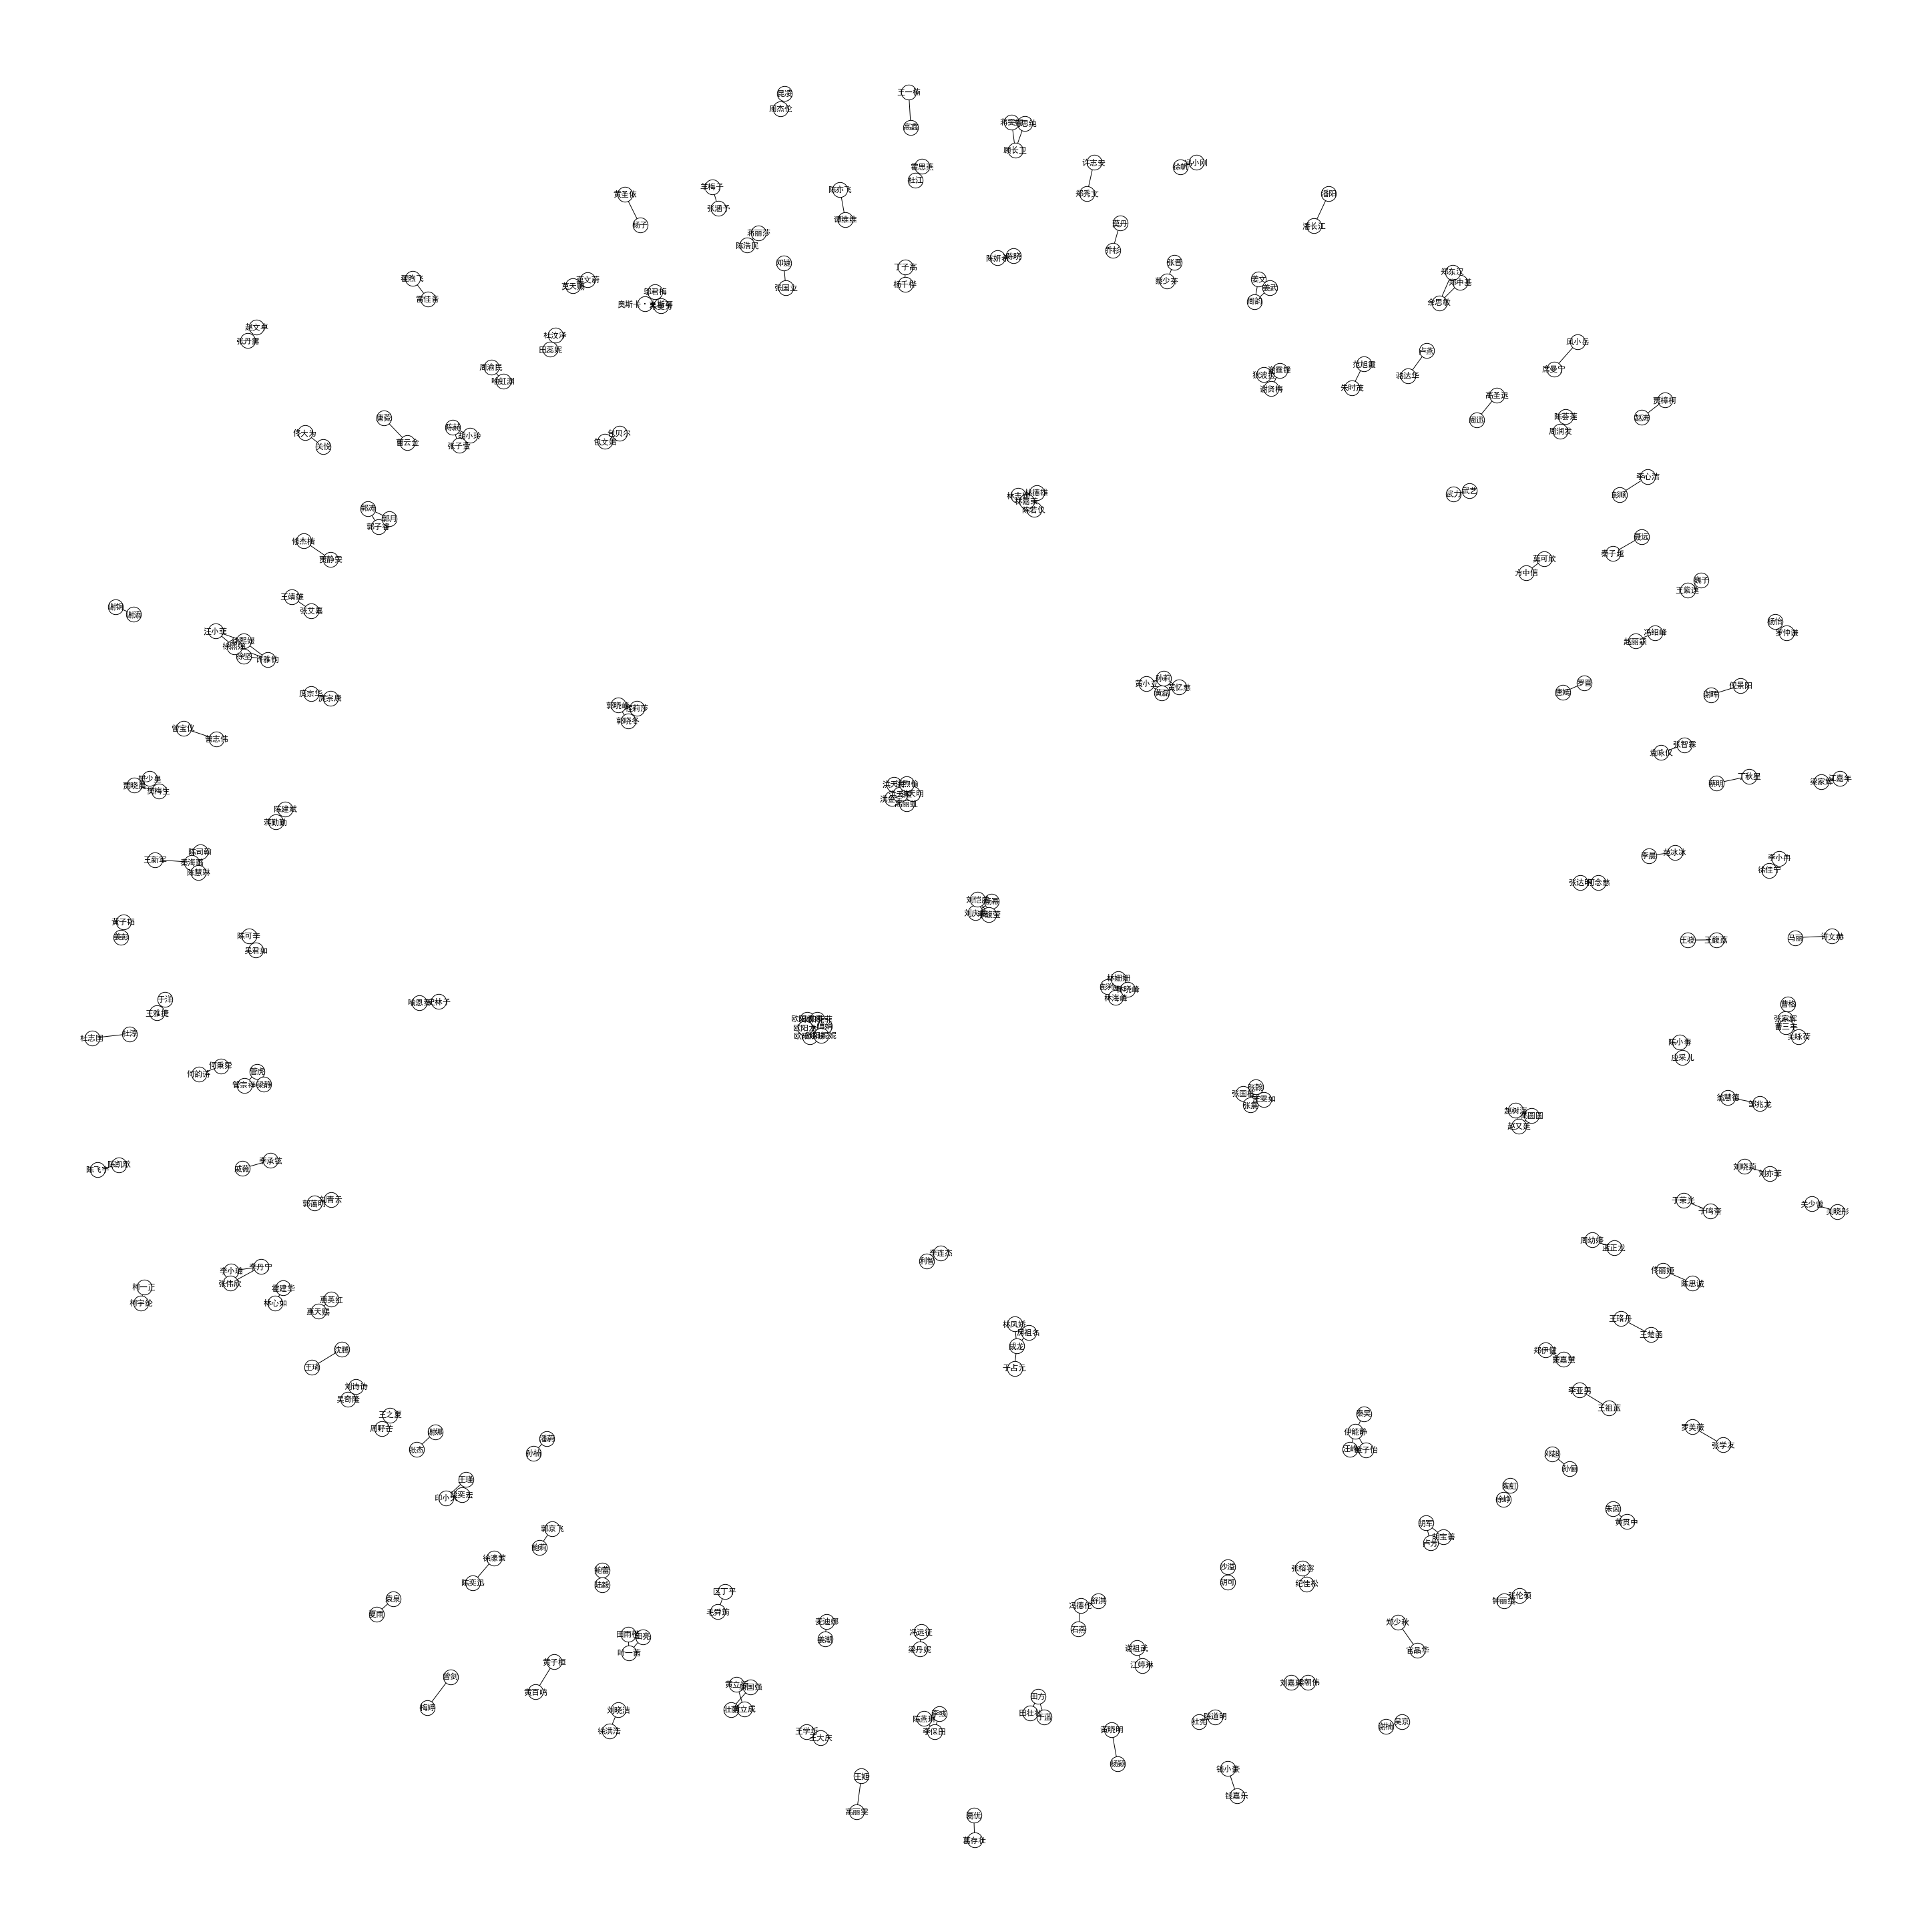

In [24]:
pos = nx.spring_layout(kin_network, scale=2, seed = 50)

plt.figure(figsize=(40,40)) 

options = {
    "font_size": 12,
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black" ,   "width": 1,
}

nx.draw(kin_network,pos = pos, with_labels = True, **options)

plt.show()

'老师','同学','前女友','前妻','前夫','前男友','干女儿', '干儿子','舅父','嫂子','圈外'

### Co-worker's Network Building

In [40]:
df = pd.read_csv('~/a_Research/Input/table_mod.csv', encoding = "GBK", header=1)

df.head()

code  year  month    name   box2019   box director1 director2     dfans  \
0     1  2009      9    建国大业  5.369108  4.16       韩三平       黄建新    5456.0   
1     2  2009     12    十月围城  3.755794  2.91       陈德森       NaN  545022.0   
2     3  2009      1   赤壁(下)  3.368599  2.61       吴宇森       NaN  233738.0   
3     4  2009     12  三枪拍案惊奇  3.329879  2.58       张艺谋       NaN       0.0   
4     5  2009      9      风声  2.891058  2.24       高群书       陈国富       0.0   

         dst  ms1     ms1fans      ms1st  fs1     fs1fans       fs1st  ms2  \
0  2011/3/23  唐国强     37179.0  2011/3/12   许晴   8381242.0   2011/3/23  张国立   
1   2010/3/9  甄子丹   6078838.0  2010/3/30  范冰冰  39431925.0  2013/12/25  梁家辉   
2  2015/7/16  梁朝伟   1504853.0  2010/5/27   赵薇  73974278.0  2009/10/28  金城武   
3        NaN  孙红雷  11381520.0  2009/9/29   闫妮    377610.0   2011/6/28  小沈阳   
4        NaN  黄晓明  39327844.0  2010/4/14   周迅   4309367.0    2011/5/4  苏有朋   

      ms2fans       ms2st  fs2     fs2fans      fs2st guests      gsfans  \
0    475478.0   2011/3/13  邬君梅    403431.0   2010/3/2     陈坤  78031895.0   
1         0.0         NaN  李宇春   3517480.0  2009/9/10    谢霆锋         NaN   
2         0.0         NaN  林志玲   9901922.0  2009/8/28    佟大为  22612580.0   
3  12835247.0   2009/8/28  NaN         NaN        NaN    赵本山   5524638.0   
4  22655876.0  2010/12/14  李冰冰  35118659.0  2009/8/28    张涵予    636765.0   

          gst      type  love  crime  history  other  family  animated  \
0  2009/11/13     历史、战争   0.0    0.0      1.0    0.0     0.0       0.0   
1         NaN     历史、战争   0.0    0.0      1.0    0.0     0.0       0.0   
2   2009/8/28     历史、战争   0.0    0.0      1.0    0.0     0.0       0.0   
3  2010/11/20  惊悚、悬疑、犯罪   0.0    1.0      0.0    0.0     0.0       0.0   
4   2009/8/28  惊悚、悬疑、犯罪   0.0    1.0      0.0    0.0     0.0       0.0   

   comedy  action  jjuj  jjij  hbij  jxiaj  jmaj  jluj  bhuj  jxioj  rank  \
0     0.0     0.0   0.0   0.0   1.0    0.0   0.0   1.0   1.0    0.0   6.1   
1     0.0     0.0   0.0   0.0   1.0    1.0   1.0   0.0   0.0    0.0   7.7   
2     0.0     0.0   0.0   0.0   1.0    1.0   0.0   0.0   0.0    0.0   6.5   
3     0.0     0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0    0.0   4.7   
4     0.0     0.0   0.0   0.0   1.0    0.0   1.0   0.0   1.0    0.0   8.0   

      total  sequels  remake                                      prize  
0  111541.0      0.0     1.0  2011华表奖优秀故事片奖、2010金鹿奖最佳华语故事片、2010百花奖最佳影片奖  
1  204435.0      0.0     1.0       2011华表奖优秀合拍片奖、2010金像奖最佳电影第47届台湾电影金马奖  
2   84042.0      1.0     1.0                    2009华表奖优秀合拍片奖，香港金像奖最佳剪接  
3   68824.0      0.0     0.0                                        NaN  
4  234005.0      0.0     1.0                2011华表奖优秀合拍片奖第30届百花奖第46届金马奖

In [26]:
df.name.value_counts()

旺扎的雨靴        2
海门深处         2
特别追踪         2
红颜容          1
乘风破浪         1
            ..
诡镇           1
密道追踪之阴兵虎符    1
最佳嫌疑人        1
恶战           1
大陈岛誓言        1
Name: name, Length: 2656, dtype: int64

In [37]:
df.name.value_counts()
df.drop(2324,axis=0,inplace=True) # '旺扎的雨靴'
df.drop(2547,axis=0,inplace=True) # '海门深处'
df.drop(2474,axis=0,inplace=True) # '特别追踪'

In [38]:
# 243 Cartoon were deleted, leaving 2413 films
attr_list = ['year','name','box2019','director1','director2','ms1', 'fs1','ms2','fs2','guests']

df = df[~df['type'].str.contains('动画')][attr_list].reset_index(drop=True)

df

year    name   box2019 director1 director2  ms1  fs1      ms2  fs2  \
0     2009    建国大业  5.369108       韩三平       黄建新  唐国强   许晴      张国立  邬君梅   
1     2009    十月围城  3.755794       陈德森       NaN  甄子丹  范冰冰      梁家辉  李宇春   
2     2009   赤壁(下)  3.368599       吴宇森       NaN  梁朝伟   赵薇      金城武  林志玲   
3     2009  三枪拍案惊奇  3.329879       张艺谋       NaN  孙红雷   闫妮      小沈阳  NaN   
4     2009      风声  2.891058       高群书       陈国富  黄晓明   周迅      苏有朋  李冰冰   
...    ...     ...       ...       ...       ...  ...  ...      ...  ...   
2408  2019   风雨同仁堂  0.000109       马崇杰       NaN  张永和  蓝荫海      王新纪  NaN   
2409  2019    禁锢之地  0.000109        吴奇       NaN  周柏豪  王真儿  罗伯特·克耐普  张丹妮   
2410  2019    相亲时代  0.000099       蒋君君       NaN  郭烁杰  李欣烨      宁小花   廖娟   
2411  2019    薪火相传  0.000099        王鼎       NaN   刘劲  NaN      刘锦航  NaN   
2412  2019   大陈岛誓言  0.000048       陈华杰       NaN  张笑君  李若嘉      刘长纯   谢芳   

     guests  
0        陈坤  
1       谢霆锋  
2       佟大为  
3       赵本山  
4       张涵予  
...     ...  
2408    NaN  
2409    NaN  
2410    NaN  
2411    NaN  
2412    NaN  

[2413 rows x 10 columns]

In [42]:
# Change the data type into string
df.loc[:, ['name', 'director1', 'director2', 'ms1', 'fs1', 'ms2', 'fs2',
       'guests']] = df[['name', 'director1', 'director2', 'ms1', 'fs1', 'ms2', 'fs2',
       'guests']].astype('str')

In [43]:
for attr in attr_list[1:]:
    
    if attr != 'box2019':
        
        df.loc[:, attr] = df[attr].apply(lambda x: x.lstrip().rstrip().replace(' ',',').lstrip(' ').rstrip(' '))

df = df[~df['director1'].str.contains('nan')].reset_index(drop=True)

In [45]:
df.loc[:, 'co_acts'] = df['director1'] + ',' + df['director2'] + ',' + df['ms1'] + ',' + df['fs1'] + ',' + df['ms2'] + ',' + df['fs2'] + ',' +  df['guests']

df.loc[:, 'co'] = df['ms1'] + ',' + df['fs1'] + ',' + df['ms2'] + ',' + df['fs2'] + ',' +  df['guests']

df.loc[:, 'co_acts'] = df['co_acts'].apply(lambda x: x.replace('nan,', '').replace(',nan','').split(','))

df.loc[:, 'co'] = df['co'].apply(lambda x: x.replace('nan,', '').replace(',nan','').split(','))

df['indicator'] = [1 if a in b else 0 for a, b in zip(df['director1'], df['co'])]

df_bi = df[['year','co_acts','indicator']]

df_bi.loc[:, 'collab'] = df_bi['co_acts'].apply(lambda x: [*combinations(x, 2)])

# df_bi[df_bi.loc[:,'indicator'] == 1]

# df_bi.iloc[df[df['director1'] == '王宝强'].index]

<ipython-input-45-081a67012634>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bi.loc[:, 'collab'] = df_bi['co_acts'].apply(lambda x: [*combinations(x, 2)])


In [46]:
colab_network = nx.Graph()

In [47]:
nodes_list = df.co_acts.sum()

print(len(nodes_list))

nodes_list = list(set(nodes_list))

print(len(nodes_list))

colab_network.add_nodes_from(nodes_list)

edges_list = df_bi.collab.sum()

# June.3rd, we've taken care of the self-join

# edges_list = list(set([item for item in df_bi.collab.sum() if item[0] != item[1]]))

colab_network.add_edges_from(edges_list)

11729
5799


In [49]:
def yearly_graph(year):
    
    df_bi_year = df_bi[df_bi.year <= year].reset_index(drop=True)
    
    yearly_graph = nx.Graph()
    
    nodes_list = df_bi_year.co_acts.sum()

    nodes_list = list(set(nodes_list))

    yearly_graph.add_nodes_from(nodes_list)

    edges_list = df_bi_year.collab.sum()

    # June.3rd, we've taken care of the self-join

    # edges_list = list(set([item for item in df_bi.collab.sum() if item[0] != item[1]]))

    yearly_graph.add_edges_from(edges_list)
    
    return(network_metric_merge(yearly_graph, 'year', 50000))

In [50]:
for item in range(2009, 2020):
    
    calculation = yearly_graph(item)
    
    calculation.to_csv(f'~/a_Research/Input/Simulation/aggregated_collaboration_network_metrics_{item}.csv', index = False)

In [51]:
pickle.dump(colab_network, open('C:/Users/lenovo/a_Research/Input/Simulation/Colab_network.pickle', 'wb'))

In [59]:
aggregated_collaboration_network_metrics = network_metric_merge(colab_network, 'collaboration_network_indicator', 100000)

aggregated_collaboration_network_metrics.head()

celebrity  degrees  degrees_centrality  betweenness_centrality  \
0       卢惠光        3            0.000517                0.000000   
1       殷慧君        8            0.001380                0.000000   
2       莫小棋       30            0.005174                0.001740   
3       蒋雪鸣        9            0.001552                0.000149   
4        哈磊        6            0.001035                0.000064   

   closeness_centrality  eigenvector_centrality  \
0              0.155907                0.000060   
1              0.186813                0.004225   
2              0.233824                0.032502   
3              0.197398                0.001764   
4              0.177821                0.000471   

   collaboration_network_indicator  
0                                1  
1                                1  
2                                1  
3                                1  
4                                1

In [60]:
aggregated_collaboration_network_metrics.to_csv('~/a_Research/Input/Simulation/aggregated_collaboration_network_metrics_simu.csv', index = False)

In [61]:
print(len(colab_network.nodes), len(colab_network.edges))

5799 20946


### Final Network

In [3]:
Final_Combined = nx.Graph() 

Geo_network = pickle.load(open('C:/Users/lenovo/a_Research/Input/Simulation/Geo_network.pickle', 'rb'))

alumni_network = pickle.load(open('C:/Users/lenovo/a_Research/Input/Simulation/Alumni_network.pickle', 'rb'))

kin_network = pickle.load(open('C:/Users/lenovo/a_Research/Input/Simulation/Kinship_network.pickle', 'rb'))

Colab_network = pickle.load(open('C:/Users/lenovo/a_Research/Input/Simulation/Colab_network.pickle', 'rb'))

In [29]:
Final_Combined.add_edges_from(Colab_network.edges)
Final_Combined.add_edges_from(kin_network.edges)
Final_Combined.add_edges_from(alumni_network.edges)
Final_Combined.add_edges_from(Geo_network.edges)

In [30]:
aggregated_final_network_metrics = network_metric_merge(Final_Combined, 'aggregated_final_network_metrics', 100000)

aggregated_final_network_metrics.head()

celebrity  degrees  degrees_centrality  betweenness_centrality  \
0       卢惠光        3            0.000524                0.000000   
1       陈家俊        6            0.001049                0.000032   
2       骆达华      157            0.027448                0.001378   
3       上官瞳        3            0.000524                0.000000   
4       殷慧君        8            0.001399                0.000000   

   closeness_centrality  eigenvector_centrality  \
0              0.247385                0.000005   
1              0.260116                0.000024   
2              0.337099                0.001301   
3              0.247385                0.000005   
4              0.256772                0.000007   

   aggregated_final_network_metrics  
0                                 1  
1                                 1  
2                                 1  
3                                 1  
4                                 1

In [55]:
aggregated_final_network_metrics.to_csv('~/a_Research/Input/Simulation/aggregated_final_network_metrics_re.csv', index = False)

In [56]:
pickle.dump(Final_Combined, open('C:/Users/lenovo/a_Research/Input/Simulation/Aggregate_network.pickle', 'wb'))

In [57]:
print(len(Final_Combined.nodes), len(Final_Combined.edges))

5856 162170


In [ ]:
nx.edges(Final_Combined, ['骆达华'])

In [68]:
Final_Combined.edges

EdgeView([('卢惠光', '陈家俊'), ('卢惠光', '骆达华'), ('卢惠光', '上官瞳'), ('陈家俊', '骆达华'), ('陈家俊', '杜奕衡'), ('陈家俊', '黎楚楚'), ('陈家俊', '杨刚'), ('陈家俊', '上官瞳'), ('骆达华', '陈旺林'), ('骆达华', '李明明'), ('骆达华', '杨紫'), ('骆达华', '杜奕衡'), ('骆达华', '林妙可'), ('骆达华', '殷悦'), ('骆达华', '郭品超'), ('骆达华', '颖儿'), ('骆达华', '杨涛'), ('骆达华', '刘艺丹'), ('骆达华', '李欣然'), ('骆达华', '上官瞳'), ('骆达华', '卢燕'), ('骆达华', '黄贯中'), ('骆达华', '钟汉良'), ('骆达华', '林子聪'), ('骆达华', '刘青云'), ('骆达华', '刘锡明'), ('骆达华', '莫少聪'), ('骆达华', '方皓玟'), ('骆达华', '元秋'), ('骆达华', '张柏芝'), ('骆达华', '惠英红'), ('骆达华', '钱小豪'), ('骆达华', '李璨琛'), ('骆达华', '周润发'), ('骆达华', '徐子珊'), ('骆达华', '吴镇宇'), ('骆达华', '张兆辉'), ('骆达华', '翁虹'), ('骆达华', '张继聪'), ('骆达华', '余诗曼'), ('骆达华', '吴启华'), ('骆达华', '何浩文'), ('骆达华', '马德钟'), ('骆达华', '陈汉娜'), ('骆达华', '蔡少芬'), ('骆达华', '邵音音'), ('骆达华', '李子雄'), ('骆达华', '梁俊一'), ('骆达华', '李治廷'), ('骆达华', '林俊贤'), ('骆达华', '梁家辉'), ('骆达华', '连晋'), ('骆达华', '古天乐'), ('骆达华', '何超仪'), ('骆达华', '刘恺威'), ('骆达华', '张曼玉'), ('骆达华', '曾志伟'), ('骆达华', '朱永棠'), ('骆达华', '陈晓东'), ('骆达华', '黄百鸣'), ('骆达华', '郭富城'), ('骆达华', '温碧霞'), ('骆达华',

##### Network Re-org

In [7]:
Colab_set = set(Colab_network.nodes())

In [6]:
set(kin_network.nodes())

5799

In [12]:
set_kin = set(kin_network.nodes()).difference(Colab_set)

In [14]:
len(set_kin)

112

In [26]:
kin_network.remove_nodes_from(set_kin)

print(len(kin_network.nodes), len(kin_network.edges))

213 79


In [27]:
aggregated_kinhood_network_metrics = network_metric_merge(kin_network, 'kinhood_network_indicator')

aggregated_kinhood_network_metrics.to_csv('~/a_Research/Input/Simulation/aggregated_kinship_network_metrics_simu_re.csv', index = False)

In [15]:
set_geo = set(Geo_network.nodes()).difference(Colab_set)

In [16]:
len(set_geo)

4

In [21]:
Geo_network.remove_nodes_from(set_geo)

print(len(Geo_network.nodes), len(Geo_network.edges))
    
aggregated_geo_network_metrics = network_metric_merge(Geo_network, 'geo_network_indicator', 1000)

aggregated_geo_network_metrics.to_csv('~/a_Research/Input/Simulation/aggregated_geo_network_metrics_simu_re.csv', index = False)

1673 69349


In [18]:
set_alumni = set(alumni_network.nodes()).difference(Colab_set)

In [23]:
alumni_network.remove_nodes_from(set_alumni)

print(len(alumni_network.nodes), len(alumni_network.edges))

1157 76150


In [25]:
aggregated_alumni_network_metrics = network_metric_merge(alumni_network, 'alumni_network_indicator', 10000)

aggregated_alumni_network_metrics.to_csv('~/a_Research/Input/Simulation/aggregated_alumni_network_metrics_simu_re.csv', index = False)

In [32]:
print(len(alumni_network.nodes), len(alumni_network.edges))

1179 76716
